In [13]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [keras-tuner]


In [14]:
import tensorflow as tf 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import keras_tuner as kt

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15744310516517911625
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7174356992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9535013131143045583
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 5070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 12.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
insurance = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/refs/heads/master/insurance.csv')
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [5]:
X = insurance.drop('charges', axis=1)
y = insurance['charges']

X.shape, y.shape

((1338, 6), (1338,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

col_transformer = make_column_transformer(
    (MinMaxScaler(), ['age', 'bmi', 'children']), 
    (OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region'])
)

col_transformer.fit(X_train)

X_train_normal = col_transformer.transform(X_train)
X_test_normal = col_transformer.transform(X_test)

X_test_normal[:2], X_test_normal[:2]

(array([[0.58695652, 0.24791499, 0.4       , 1.        , 0.        ,
         1.        , 0.        , 1.        , 0.        , 0.        ,
         0.        ],
        [0.39130435, 0.37826204, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 0.        ,
         0.        ]]),
 array([[0.58695652, 0.24791499, 0.4       , 1.        , 0.        ,
         1.        , 0.        , 1.        , 0.        , 0.        ,
         0.        ],
        [0.39130435, 0.37826204, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 0.        ,
         0.        ]]))

In [7]:
type(X_test_normal), X_train_normal.shape

(numpy.ndarray, (1070, 11))

## Common activation Types for Dense Layers:

**'relu' (Rectified Linear Unit):** max(0, x) - Most common for hidden layers, computationally efficient.

**'sigmoid':** Squashes values to between 0 and 1, good for binary classification output or older models.

**'tanh' (Hyperbolic Tangent):** Squashes values to between -1 and 1, often better than sigmoid in hidden layers.

**'softmax':** Converts outputs to a probability distribution (sums to 1), ideal for multi-class classification output.

**'linear' (or None):** No activation, preserves the input's linear relationship (output = dot(input, kernel) + bias).

**'leaky_relu':** A variant of ReLU that allows small negative values, preventing dying neurons. 


In [11]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(11,)),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
], name="Model_A")

model.compile(loss=tf.keras.losses.mae, 
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
             metrics=['mae', 'mse'])

model.summary()

hist = model.fit(X_train_normal, y_train, epochs=150, verbose=0)
model.evaluate(X_test_normal, y_test)

Model: "Model_A"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               1200      
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11401 (44.54 KB)
Trainable params: 11401 (44.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
9/9 [==============================] - 0s 2ms/step - loss: 1754.6503 - mae: 1754.6503 - mse: 21231478.0000


[1754.6502685546875, 1754.6502685546875, 21231478.0]

<Axes: >

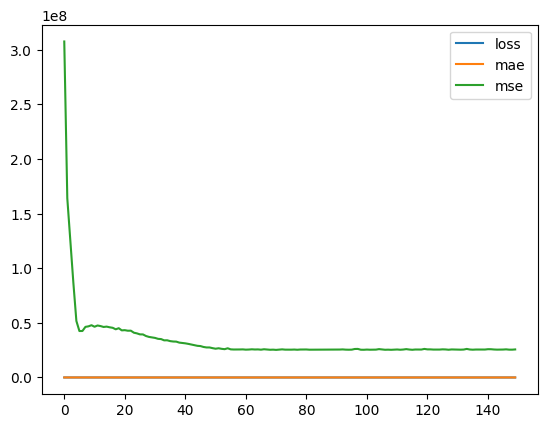

In [12]:
pd.DataFrame(hist.history).plot() 


In [26]:
## Model Optimization with keras-tuner

import keras              # standalone Keras 3
import keras_tuner as kt

def build_model(hp: kt.HyperParameters):
    # Keras 3 seed helper
    keras.utils.set_random_seed(42)

    units_1 = hp.Choice('units_1', [64, 100, 128])
    units_2 = hp.Choice('units_2', [64, 100, 128])
    lr = hp.Choice('learning_rate', [0.001, 0.005, 0.01])

    model = keras.Sequential(name="Model_A")
    model.add(keras.layers.Input(shape=(11,)))
    model.add(keras.layers.Dense(units_1, activation='relu'))
    model.add(keras.layers.Dense(units_2, activation='relu'))
    model.add(keras.layers.Dense(1))

    model.compile(
        loss="mae",
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=["mae", "mse"]
    )
    return model


In [27]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=7,
        min_lr=1e-5
    ),
]


In [28]:
tuner = kt.GridSearch(
    hypermodel=build_model, 
    objective='val_mae', 
    overwrite=True, 
    seed=42, 
    directory='kt_dir',
    project_name='model_a_grid'
)

In [29]:
tuner.search(
    X_train_normal,
    y_train,
    validation_data=(X_test_normal, y_test),
    epochs=150,
    callbacks=callbacks,
    verbose=1
)

Trial 27 Complete [00h 00m 12s]
val_mae: 1736.152587890625

Best val_mae So Far: 1727.75634765625
Total elapsed time: 00h 07m 51s


In [30]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best units_1:", best_hp.get('units_1'))
print("Best units_2:", best_hp.get('units_2'))
print("Best learning rate:", best_hp.get('learning_rate'))

best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

history = best_model.fit(
    X_train_normal,
    y_train,
    validation_data=(X_test_normal, y_test),
    epochs=150,
    callbacks=callbacks,
    verbose=0
)

best_model.evaluate(X_test_normal, y_test)


Best units_1: 128
Best units_2: 64
Best learning rate: 0.01


Model: "Model_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1730.2999 - mae: 1730.2999 - mse: 20576800.0000 


[1727.75634765625, 1727.75634765625, 20857214.0]

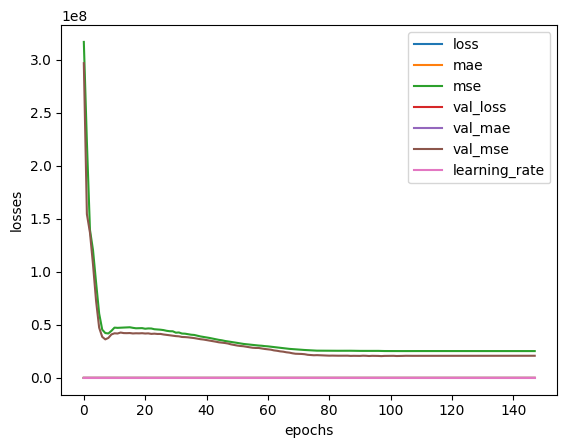

In [31]:
pd.DataFrame(history.history).plot()
plt.ylabel('losses')
plt.xlabel('epochs')
plt.legend();

In [32]:
pd.DataFrame(history.history)

,loss,mae,mse,val_loss,val_mae,val_mse,learning_rate
0,13130.181641,13130.181641,316589248.0,11915.446289,11915.446289,296576832.0,0.01000
1,9825.958008,9825.958008,222247056.0,8305.598633,8305.598633,154307824.0,0.01000
2,7661.452148,7661.452148,139563072.0,7567.987793,7567.987793,136907360.0,0.01000
3,6943.638184,6943.638184,120279568.0,6721.517578,6721.517578,106676376.0,0.01000
4,5818.378418,5818.378418,89770504.0,5048.582520,5048.582520,72409192.0,0.01000
...,...,...,...,...,...,...,...
143,1971.485229,1971.485229,25328674.0,1733.238159,1733.238159,20836020.0,0.00250
144,1966.681763,1966.681763,25320510.0,1729.959717,1729.959717,20880628.0,0.00250
145,1960.708374,1960.708374,25292332.0,1738.586060,1738.586060,20860022.0,0.00250
146,1970.421997,1970.421997,25310624.0,1729.281616,1729.281616,20859682.0,0.00250


## 1. Tune more than just units & lr

Right now you’re only searching over:

units_1

units_2

learning_rate

## You can add:

L2 regularization (to reduce overfitting)

Dropout rate

Batch size

Example: extend your build_model:
2. Use a smarter tuner than GridSearch

GridSearch explodes combinatorially and often wastes trials. For neural nets, RandomSearch or BayesianOptimization usually find better configs faster.

Example: